# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

<div style="background-color:#fff1e0;">**Answer: ** This is a classification problem. The goal is to predict a discrete (in this case binary) output - does the student require early intervention or not before they fail to graduate? Although we want a yes / no answer to our question, it will be extremely useful to have an associated probability with the result. Since resources are limited -- schools never have unlimited money -- they will want to understand the probability that a student is in danger of not graduating so they can properly manager resources.</div>

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [17]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Pretty display for notebooks
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['bmh'])

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


In [18]:
# Examine first 5 rows of data
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [19]:
# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features
n_features = student_data.shape[1] - 1 # -1 as to not count the target column

# TODO: Calculate passing students
n_passed = len(student_data[student_data['passed'] == 'yes'])

# TODO: Calculate failing students
n_failed = len(student_data[student_data['passed'] == 'no'])

# TODO: Calculate graduation rate
grad_rate = (n_passed / float(n_students)) * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


In [20]:
# Are there missing values in our data?
print ("Total missing values: ", student_data.isnull().sum().sum())

('Total missing values: ', 0)


In [21]:
# Combining Fedu and Medu into one variable
student_data["Pedu"] = student_data["Fedu"] + student_data["Medu"]
student_data = student_data.drop("Fedu", axis=1)
student_data = student_data.drop("Medu", axis=1)

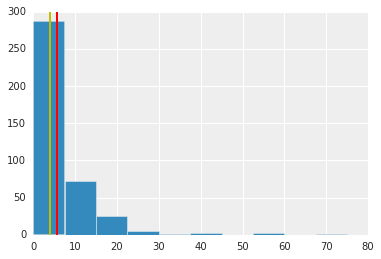

In [22]:
# Examining distribution of absences variable
absent = student_data["absences"]
hgram = absent.hist()
ymin, ymax = hgram.get_ylim()
hgram.vlines(x=np.mean(absent), ymin=ymin, ymax=ymax-1, color='r')
hgram.vlines(x=np.median(absent), ymin=ymin, ymax=ymax-1, color='y')

<div style="background-color:#fff1e0;">No matter what how you dice it, having failures > 0 seems to indicate a higher rate of non-graduation.</div>

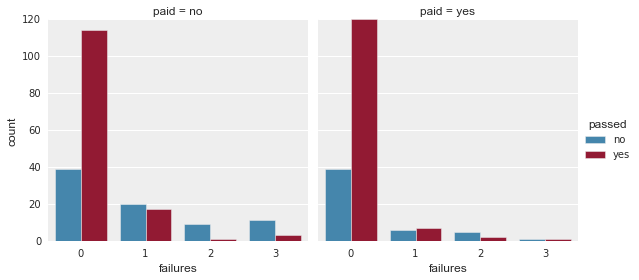

In [23]:
import seaborn as sns
sns.factorplot("failures", col="paid", data=student_data, hue='passed', kind="count");

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [24]:
# Extract feature columns
feature_cols = list(student_data.ix[:, student_data.columns != "passed"].columns)

# Extract target column 'passed'
target_col = list(student_data[["passed"]].columns)[0]

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'Pedu']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus     Mjob      Fjob  reason guardian  \
0     GP   F   18       U     GT3       A  at_home   teacher  course   mother   
1     GP   F   17       U     GT3       T  at_home     other  course   father   
2     GP   F   15       U     LE3       T  at_home     other   other   mother   
3     GP   F   15       U     GT3       T   health  services    home   mother   
4     GP   F   16       U     GT3       T    other     other    home   father   

  ...   internet  romantic  famrel freetime goout Dalc Walc health absences  \
0 ...         no        no       4        3     4    1    1      3        6

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [25]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (47 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'Pedu']


In [26]:
# Examine first 5 rows of data
X_all.head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Pedu
0,1.0,0.0,1.0,0.0,18,0.0,1.0,1.0,0.0,1.0,...,0,0,4,3,4,1,1,3,6,8
1,1.0,0.0,1.0,0.0,17,0.0,1.0,1.0,0.0,0.0,...,1,0,5,3,3,1,1,3,4,2
2,1.0,0.0,1.0,0.0,15,0.0,1.0,0.0,1.0,0.0,...,1,0,4,3,2,2,3,3,10,2
3,1.0,0.0,1.0,0.0,15,0.0,1.0,1.0,0.0,0.0,...,1,1,3,2,2,1,1,5,2,6
4,1.0,0.0,1.0,0.0,16,0.0,1.0,1.0,0.0,0.0,...,0,0,4,3,2,1,2,5,4,6


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [27]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Determine proportion of dataset allocated to test set
test_size = num_test / float(X_all.shape[0])

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all, test_size=test_size, random_state=42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


In [28]:
# Ensure sampling is maintained similar target balance
print "Grad rate of train set: {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Grad rate of test set: {:.2f}%".format(100 * (y_test == 'yes').mean())

Grad rate of train set: 67.00%
Grad rate of test set: 67.37%


In [29]:
# Just curious... which features does selectkbest like?
from sklearn.feature_selection import SelectKBest
skbestys = SelectKBest(k=10)
skbestys.fit_transform(X_train, y_train)
bestys = []
for el in range(len(skbestys.get_support())):
    if skbestys.get_support()[el]:
        bestys.append(X_train.columns[el])
print bestys

['age', 'Mjob_health', 'Fjob_other', 'guardian_other', 'failures', 'schoolsup', 'paid', 'higher', 'goout', 'Pedu']


<div style="background-color:#fff1e0;">SelectKBest is enlightening for two primary reasons. First, I am surprised that absences is not one of SelectKBest's features. Both intuitively and looking later at feature importances from the decision tree classifier, I believe that would be an influential factor in predicting graduation. Second, as I experimented with modeling and varying the number of features used, I saw that using fewer features lead to better performace of the models. No doubt that this has a lot to do with the ratio of observations to features in this dataset.  
<br><br>
Note that I am not limiting my feature selection based on SelectKBest, I was simply curious to see it's output. When I build my models, I will use the full feature set.</div>

## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

<div style="background-color:#fff1e0;">Each of the models above can be used for binary classification. In order to narrow the choices, I began by trying to understand if the problem is or is not linearly seperable. To gain intuition for this, I ran a SVM with a linear RBF kernel. As shown below, when I determine that the prediction accuracy on this data with this model is far from perfect, I conclude that the problem is not linearly separable. Even if there exist some outliers in the data, the classification error is too high to be attributable to these data points. (Sidebar - in order to prove this to myself I created a faux dataset that was definitively linearly seperable and showed myself that the classification error using a linear SVM was indeed 0%.)</div>

In [30]:
# Is data linearly seperable?
# Looking for close to 0% error with linear SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(kernel='linear')
clf.fit(X_train, y_train) 
print ('Linear SVM Accuracy: ', accuracy_score(y_test, clf.predict(X_test)))

('Linear SVM Accuracy: ', 0.65263157894736845)


<div style="background-color:#fff1e0;">I am making the assumption that this dataset is not linearly separable. As such, using this <a href='https://azure.microsoft.com/en-us/documentation/articles/machine-learning-algorithm-choice/'>Microsoft Azure blogpost for choosing algorithms</a>, I am limiting the models assumed to be appropriate for this problem to:  
- Decision Trees  
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)  
- K-Nearest Neighbors (KNeighbors)  
- Support Vector Machines (SVM)  
Note: <a href='http://stats.stackexchange.com/questions/215696/do-all-machine-learning-algorithms-separate-data-linearly/215763'>This post on Cross Validated</a> talking about machine learning algorithms that separate data linearly helped narrow the selection. Additionally, <a href='https://www.youtube.com/watch?v=3liCbRZPrZA&feature=youtu.be'>this video</a> really helps conceptualize what it means to be linearally separeable.</div>

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

<div style="background-color:#fff1e0;">
**Data Summary Q&amp;A:**
</div>
- How much data do you have? The dataset contains 395 samples. When using 75% of the data for training our model, this number reduced to approximately 300 training points. I consider this a moderate size dataset (not tiny, but definitely not big).  
- How many features are there? Originally, we start with 30 features. After preprocessing the data to make categorical variables into numeric features as dummy variables, we have 48 features. This is moderately high dimensionality (especially in comparison to the # of observations).  
- What's the ratio of observations to features? 300 / 48 = 6.25. Using the training set, the ratio of observations to features is 6.25.  
- Are there outliers that should be removed? I will not be removing any data points as outliers for this analysis.  
- Is the problem linearaly seperable? As noted above, the problem is not linearally separable and will wiegh heavily on algorithm choice.

**Model Investigation:**
<div style="background-color:#fff1e0;">
Below, I explore the advantages and weaknesses of 4 supervised learning models: Decision Tree, Ensemble Methods, KNN, and non-linear SVMs.</div>

<div style="background-color:#fff1e0;">
<em>Decision Trees:</em>  
<br><br>
Decision trees have excellent accuracy. In fact, sometimes they fit the training data too well and tend to overfit. This occurs when the dataset is small or large. These models have moderate training times - especially when there are a very large number of features -- but tend to scale very well as more data is acquired. A unique attribute of decision trees is their ability to provide feature importances to the modeler - this means we can dig in remove features (reduce model complexity) which don't contribute to performance improvement. Lastly, decision trees are not effected by outliers (even though I am assuming no outliers) or scale normalization. Decision trees are easy to work with right out of the box and provide good accuracy for problems, such as this one, that are not linearally separable. These models good at handling messy data, aasy to interpret their output, and you can also see prediction probabilities. 
<br><br>
<em>Decision Trees Industry Application:</em>
The research paper discusses the application of decision tree learning for predicting the checkout of library books in order to make more likely to be checked out book available on location and less likely checked out books stored in a more efficient offsite storage area.</div> http://booksite.elsevier.com/9780124438804/leondes_expert_vol1_ch3.pdf

<div style="background-color:#fff1e0;">
<em>K-Nearest Neighbors (KNeighbors):</em>  
<br><br>
KNN works well with large amounts of observations and relatively low number of dimensions aka features and in such circumstances can be very effective. KNN is a instance-based learner which means it holds on to all of the data points in order to make a prediction about future data -- a less than computationally efficient approach (they take up a lot of memory). Easy to interpret output. You can also see prediction probabilities.  
<br><br>
<em>KNN Indusrty Application:</em>
KNN is used in the credit card industry to identify fraudulent transactions. This Dummies article (link below) discusses how KNN identifies purchases that are not like the others and ask customers to validate the purchase. This has happened to me personally a few times over the past year (United Mileage card). Additionally, I watched an O'Reilly video where they talked about the use of KNN in credit fraud detection since it works well with unbalanced dataset (non-fraudulent transactions much more common that fraudulent transactions). So, this appears to be a sort of outlier detection problem. This seems very relavent to our student intervention problem where more students graduate than don't.</div> http://www.dummies.com/programming/big-data/data-science/solving-real-world-problems-with-nearest-neighbor-algorithms/

<div style="background-color:#fff1e0;">
<em>(Non-linear) Support Vector Machines (SVM):</em>  
<br><br>
I've tried to run non-linear kernel SVM's on high dimensional data... and it took forever. That is absolutely the biggest drawback of this model type. Additionally, the output is difficult to explain (the black box curse). Aside from those drawbacks, SVM's can be highly accurate for problems with many observations and problems, such as this one, that are not linearally separable.  
<br><br>
<em>SVM Industry Application:</em>
This research article (link below) investigates the use of SVM modeling to predict an individual's risk of getting diabetes. These researches use features such as family history, age, gender, BMI, and so to predict if the indivudal is or is not at risk of getting diabetes. It talks about the success of the algorithm on low observations / high dimension datasets, which is premium for our dataset.</div> https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-10-16

<div style="background-color:#fff1e0;">
<em>Ensemble Methods:</em>
<br><br>
Ensemble methods, such as bagging &amp; boosting, build several instances of a model (decision tree, knn, svm, and so on) on random subsets of the data and then aggregate their individual predictions to form a final prediction. A fantastic analogy for ensemble models is that generally, groups of people can make better decisions than any one individual. The major advantages of such models is high accuracy and the ability to avoid overfitting - assuming you are using the right ensemble method to solve the problem at hand (bagging helps when models have high variance and boosting helps when models have high bias). On the other hand, ensemble methods can we computationally expensive compared to standalone models like decision trees. More difficult to explain results than with other models. You can also see prediction probabilities.  
<br><br>
<em>Ensemble Methods Industry Application:</em>
This research paper discusses several ensemblem methods and their applications. One example focuses on random forest classification of mountainous terrain using data from sensors. The technique is well suited to the problem, according to the article, since random forest -- which makes its classification based on the decision of many decision trees -- works well with data that may be noisy or incomplete. Since our dataset for student intervention is complete, an approach with random forest classification may not be the best choice.</div> https://www.researchgate.net/publication/222425707_Classifier_ensembles_Select_real-world_applications 

<div style="background-color:#fff1e0;">
Based on the model investigation, this report will move forward with 3 models: Decision Trees, K-Nearest Neighbors, and a non-linear SVM.</div>

<div style="background-color:#fff1e0;">
Resources:</div>
https://azure.microsoft.com/en-us/documentation/articles/machine-learning-algorithm-choice/  
http://www.simafore.com/blog/bid/62333/4-key-advantages-of-using-decision-trees-for-predictive-analytics  
http://scikit-learn.org/stable/modules/ensemble.html  
http://stats.stackexchange.com/questions/109831/why-not-always-use-ensemble-learning  

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [31]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the model
    # print clf
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [32]:
print "\nF1 score for predicting all 'yes': {:.4f}".format(
    f1_score(y_true = ['yes']*n_passed + ['no']*n_failed,
             y_pred = ['yes']*n_students,
             pos_label = 'yes', 
             average = 'binary'))


F1 score for predicting all 'yes': 0.8030


<div style="background-color:#fff1e0;">Before building classifiers and recording scores, I am noting the benchmark performance when predicting class of all 1 (passing) for every case. In this case, our accuracy would be 0.67, recall would be 1.0 and precision would be 0.67. Additionally, our benchmark F1 score would be 0.8030.  
<br>
Note that I did experiment using 1 to indicate non-passers, but didn't see an extraordinary difference in the results. Hence, I kept 1 predictions to indicate passing students. 
</div>

In [33]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = KNeighborsClassifier()
clf_C = SVC()

# TODO: Set up the training set sizes
# Removed this section and incorporated it in my for loop below

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# Hiding results for final output since summarized in tables below
for clf in [clf_A, clf_B, clf_C]:
    for n in [100, 200, 300]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print ('\n')

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0011 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0005 seconds.
F1 score for test set: 0.6667.


Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0022 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0004 seconds.
F1 score for test set: 0.6721.


Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0018 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.6833.


Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0009 seconds
Made predictions in 0.0022 seconds.
F1 score for training set: 0.8356.
Made predictions in 0.0014 seconds.
F1 score for test set: 0.7671.


Training a KNeighborsClass

In [34]:
# a little experiment to view probabilities
print ("Actual: ", y_test.iloc[0], y_test.iloc[2], y_test.iloc[12])
print ("Probabilities: ", clf_B.predict_proba(X_test)[0],
       clf_B.predict_proba(X_test)[2],
       clf_B.predict_proba(X_test)[12])
print ("Predictions: ", clf_B.predict(X_test)[0],
       clf_B.predict(X_test)[2],
       clf_B.predict(X_test)[12])

('Actual: ', 'yes', 'no', 'yes')
('Probabilities: ', array([ 0.,  1.]), array([ 0.2,  0.8]), array([ 0.6,  0.4]))
('Predictions: ', 'yes', 'yes', 'no')


<div style="background-color:#fff1e0;">The experiment above shows why I have chosen to move forward with the KNN algorithm over the SVC classifer despite the slightly better performance of the latter. The KNN model shows me the probabilities associated with each student in terms of not pass / pass. In the first example, the student graduated and our model predicted graduation with 100% probability. In the second example, the student did not graduate, but our model predicted graduation with 80% probability. In the third example, the student graduated, but our model only predicted a 40% chance of graduating and ultimately predicted not graduate. When the stakes are so high (student's lives depend on it), I think it is important to drill down into these probabilities rather than taking the output from our SVC classifier without question.</div>

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - DecisionTreeClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0012           |        0.0004          |     1.0000       |    0.6667       |
| 200               |        0.0011           |        0.0002          |     1.0000       |    0.6721       |
| 300               |        0.0033           |        0.0004          |     1.0000       |    0.6833       |

** Classifer 2 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0007           |        0.0018          |     0.8356       |    0.7671       |
| 200               |        0.0010           |        0.0020          |     0.8207       |    0.8000       |
| 300               |        0.0013           |        0.0032          |     0.8578       |    0.7945       |

** Classifer 3 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0019           |        0.0020          |     0.9924       |    0.7949       |
| 200               |        0.0045           |        0.0013          |     0.9852       |    0.8105       |
| 300               |        0.0063           |        0.0014          |     0.9950       |    0.8235       |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** 
<div style="background-color:#fff1e0;"> 
We've chosen to move forward with the KNN classifier in order to identify and help students that, based on their demographic metrics such as age, access to internet at home, and parents level of education, are in jeopardy of not graduating. Although KNN is better suited to problems with more observations and relatively less features, its performance (in terms of F1-score) relative to the other models was acceptable. KNN excels with problems, such as this one, where the dataset is unbalanced meaning there are less non-graduates than graduates.  
<br><br>
Our KNN is not the fastest model we have, in terms of either time to train the model or time make a prediction on a student, but it's not the slowest either. Similarly, this model is neither the best or worst performer (in terms of F1-score). However, the trade-off is in its ability to share its decision making method with us by providing probabilities of pass / not pass for each student prediction. As noted above, I believe its crucial to have these metrics when our classifiers are far from perfect.  
<br><br>
As we collect more student data and attempt to retrain and improve the performance of our model, we need to keep in mind that A) the KNeighborsClassifier will perform better and B) is an instance based learner which means the cost of training a new model will rise and the cost of carrying the model will rise too. Although it is likely that with more data, we'll get more accurate predictions, this classifier will also need to keep data points with it as we use it to make those more accurate predictions.
</div>

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **
<div style="background-color:#fff1e0;">
The model chosen, K-nearest neighbors (KNN), is incredibly intuitive in how it works. The model groups together observations by calculating their distance (either Euclidean or Manhattan distance) from one another. Imagine a 2-dimensional box containing 3 data points, two of the points are in the lower left hand corner of the box and the third point is in the upper right hand corner of the box. Additionally, assume we have 2 groups or neighborhoods. If we measured the distance between the points we would discover that the 2 points in the lower left hand corner are closer together than either of them is to the point in the upper right hand side of the box. These points have been grouped together by calculating their proximity to one another and we assume they live in a different neighborhood than the other point in the upper right hand side. Lastly, imagine we added a 4th data point in the lower center of the box and wanted to know which neighborhood it belongs to. Our algorithm would measure the distance from that point to the 2 points in the lower left hand side of the box and then to the 1 point in the upper right hand side of the box. I would imagine, assuming there is only 2 groups, that this new point would be grouped with the 2 points in the lower left hand side of the box because it is closer to them.  
<br><br>
We use that same intuition when calculating the distance between the data points of our students. The goal is to identify neighborhoods where students are less likely to graduate. When we can identify those neighborhoods (or groups) we can distribute more resources to those students to improve their chances of a successful outcome (graduating).
</div>

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [35]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {"clf__n_neighbors" : [4, 6, 8, 10],
              "clf__weights"     : ["uniform", "distance"],
              "clf__p"           : [1, 2],
              "clf__leaf_size"   : [20, 30]    
             }

# TODO: Initialize the classifier
clf = KNeighborsClassifier()

# Create pipeline to normalize data
pipe = Pipeline([('clf', clf)])

# Deal with class imbalance. Make sure training sets have balanced targets
cv = StratifiedShuffleSplit(y_train, n_iter=100, random_state=0)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=pipe, param_grid=parameters, scoring=f1_scorer, cv=cv, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

print clf

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))
print "F1 score for predicting all \"yes\" on test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))

Pipeline(steps=[('clf', KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=1,
           weights='distance'))])
Made predictions in 0.0070 seconds.
Tuned model has a training F1 score of 1.0000.
Made predictions in 0.0023 seconds.
Tuned model has a testing F1 score of 0.8082.
F1 score for predicting all "yes" on test set: 0.8050


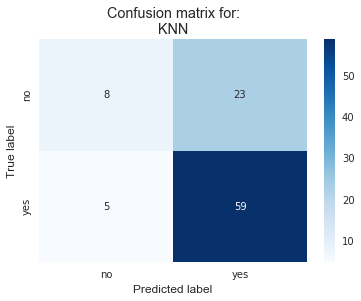

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.values, clf.predict(X_test))

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format("KNN"));

<div style="background-color:#fff1e0;">The confusion matrix above for our final KNN model is telling. The light-ish blue box in the upper right hand corner is troubling. These are students for whom our model predicted they would graduate, but actually they did not graduate. If our model could have identified these students as less likely to graduate, perhaps we could have shifted resources to give them more help. Less troubling, but still problematic, are the students that fall into the lower left hand box. These are students for which our model predicted will not graduate, but actually they did. This means we would utilizing additional resources on these students who probably did not need it.</div>

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **
<div style="background-color:#fff1e0;">
The final model's F<sub>1</sub> score for training is 1.0 and for testing is 0.8082, only slightly higher than guessing 1's (or graduate) for every student. Our prior untrained model had a testing F<sub>1</sub> score of 0.7945 on all 300 training observations, so tuning the model improved performance slightly.</div>

<div style="background-color:#fff1e0;">In order to improve this model further there are two immediate steps I would take. The first is to collect more student data. More observations will make the performance much more reliable. Secondly, I would experiment using a lesser number of features. KNN works better in lower dimensional spaces. If we identified the most important features (through SelectKBest and decision tree feature importances) we could build a less complex model that performs just as well as the current model. Thus, reducing computation cost when recalibrating the model and also less storage cost since KNN is an instance based learner and needs to carry the observations with it in order to make predictions on future data.
</div>

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.